## Семинар 2 "Распознавание рукописных цифр"

ФИО: Долгая Любовь Васильевна

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
import torch
%matplotlib inline

In [26]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    print(X, y)
    y = y.numpy()
    break
    #в конце классы картинок

[[-0.42421296 -0.42421296 -0.42421296 ... -0.42421296 -0.42421296
  -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 ... -0.42421296 -0.42421296
  -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 ... -0.42421296 -0.42421296
  -0.42421296]
 ...
 [-0.42421296 -0.42421296 -0.42421296 ... -0.42421296 -0.42421296
  -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 ... -0.42421296 -0.42421296
  -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 ... -0.42421296 -0.42421296
  -0.42421296]] tensor([8, 0, 8, 7, 3, 5, 2, 9, 8, 6, 3, 3, 1, 2, 4, 4, 9, 9, 8, 1, 8, 3, 9, 0,
        3, 7, 0, 9, 8, 8, 0, 2])


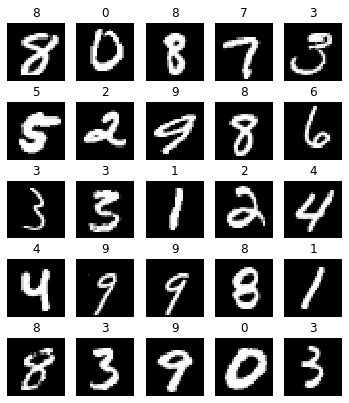

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [29]:
layers = [Linear(784, 100), Sigmoid(),
         Linear(100, 100), Sigmoid(), Linear(100, 10)]
nn = NeuralNetwork(layers)

In [30]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 19... (Train/Test) NLL: 0.261/0.258	Accuracy: 0.929/0.929

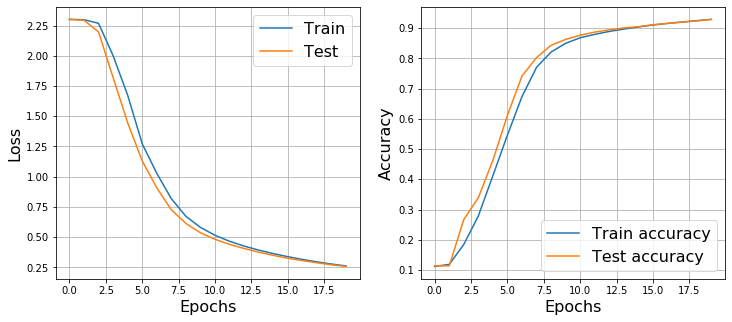

In [20]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(nn, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [7]:
class ReLu:
    def __init__(self):
        pass
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dLdy):
        return dLdy * (self.x > 0)
    
    def step(self, learning_rate):
        pass

In [8]:
class ELU:
    def __init__(self, a = 1):
        self.a = a
    
    def forward(self, x):
        self.x = x
        return x * (x > 0) + self.a * (np.exp(x) - 1) * (x <= 0)
    
    def backward(self, dLdy):
        return dLdy * ((self.x > 0) + self.a * (np.exp(self.x)) * (self.x <= 0))
        
    
    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.164/0.070	Accuracy: 0.949/0.977

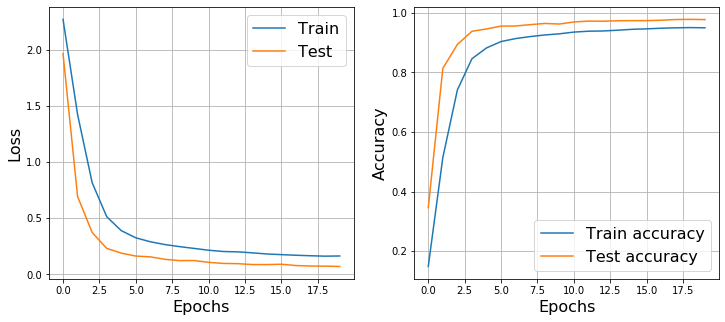

In [44]:
layers_cur = [Linear(784, 100), ReLu(),
            Linear(100, 100), ReLu(), Linear(100, 10)]
nn_cur = NeuralNetwork(layers_cur)
tr_s, ts_s_ReLu, tr_ac_s, ts_ac_s_ReLu = train(nn_cur, 20, 0.01)  

Epoch 19... (Train/Test) NLL: 0.168/0.073	Accuracy: 0.948/0.977

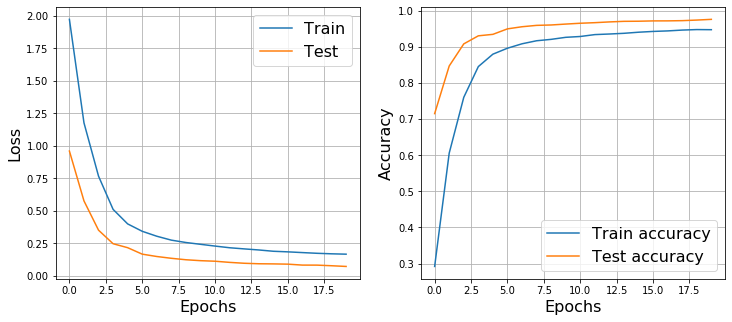

In [42]:
layers_cur = [Linear(784, 100), ELU(),
            Linear(100, 100), ELU(), Linear(100, 10)]
nn_cur = NeuralNetwork(layers_cur)
tr_s, ts_s_ELU, tr_ac_s, ts_ac_s_ELU = train(nn_cur, 20, 0.01) 

Epoch 19... (Train/Test) NLL: 0.953/0.684	Accuracy: 0.695/0.820

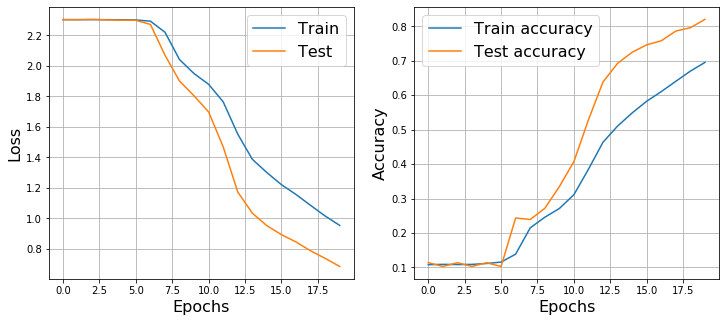

In [43]:
layers_cur = [Linear(784, 100), Sigmoid(),
            Linear(100, 100), Sigmoid(), Linear(100, 10)]
nn_cur = NeuralNetwork(layers_cur)
tr_s, ts_s_Sigm, tr_ac_s, ts_ac_s_Sigm = train(nn_cur, 20, 0.01)  

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

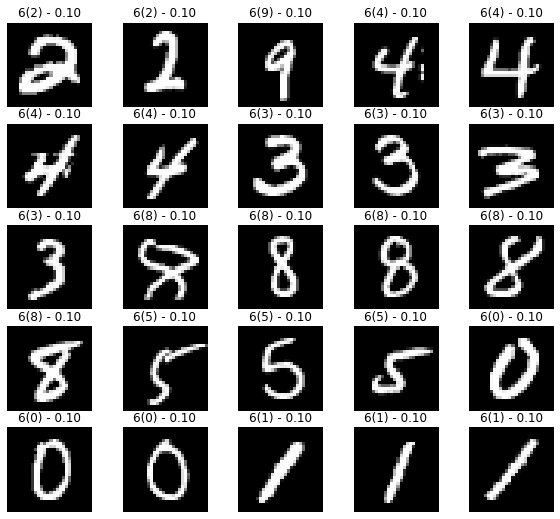

In [9]:
for X, y in test_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy()
    y = y.numpy()
    
    predictions = nn.forward(X)
    predictions = np.exp(predictions)
    predictions = predictions / np.sum(predictions, axis=1, keepdims=True)
    prob = predictions[range(X.shape[0]), y]
    ind = np.argsort(prob)[:25]
    plt.figure(figsize=(10, 9))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(X[ind[i], :].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title('{}({}) - {:.2f}'.format(np.argmax(predictions[ind[i], :]), y[ind[i]], prob[ind[i]]))
        plt.axis('off')
    break

### HW1 (1 балл): Реализовать Tanh

In [10]:
class Tanh:
    def __init__(self, a = 1):
        self.a = a

    def forward(self, x):
        self.x = x
        return np.tanh(x)
    
    def backward(self, dLdy):
        return dLdy * (1 - np.power(np.tanh(self.x), 2))

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.030/0.075	Accuracy: 0.994/0.977

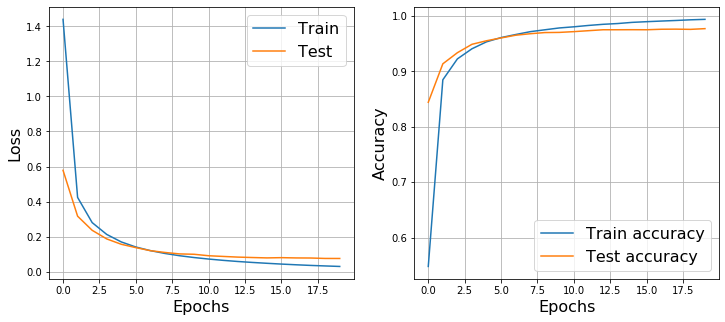

In [27]:
layers_cur = [Linear(784, 100), Tanh(),
            Linear(100, 100), Tanh(), Linear(100, 10)]
nn_cur = NeuralNetwork(layers_cur)
tr_s, ts_s_Tanh, tr_ac_s, ts_ac_s_Tanh = train(nn_cur, 20, 0.01) 

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [36]:
from skimage.transform import rotate
from PIL import Image, ImageFilter

In [37]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

### Шум

In [38]:
layers = [Linear(784, 100), Sigmoid(),
         Linear(100, 100), Sigmoid(), Linear(100, 10)]
nn = NeuralNetwork(layers)

Epoch 19... (Train/Test) NLL: 0.326/0.312	Accuracy: 0.912/0.916

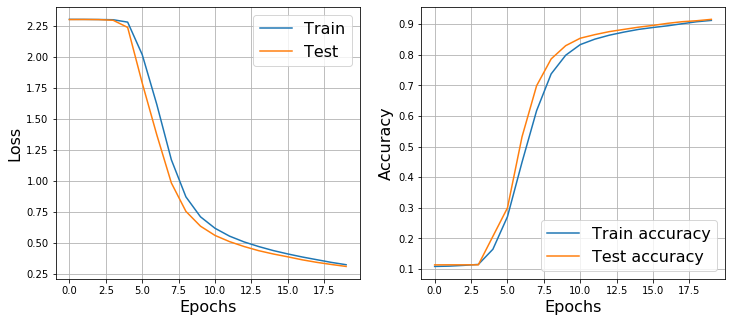

In [15]:
transform_cur = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_cur = MNIST('.', train=True, download=True, transform=transform_cur)
test_dataset_cur = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset_cur, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_cur, batch_size=32, shuffle=True)

tr_s, ts_s, tr_ac_s, ts_ac_s = train(nn, 20, 0.01)

### Небольшие вращения (-15, 15)

Epoch 19... (Train/Test) NLL: 0.364/0.307	Accuracy: 0.901/0.918

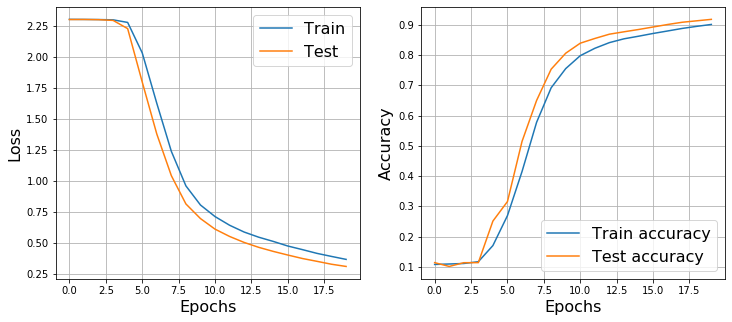

In [43]:
transform_cur = transforms.Compose([
#                        transforms.RandomRotation(15),
                        transforms.RandomAffine([-15,15]),
    
                       transforms.ToTensor(),
    
                       transforms.Normalize((0.1307,), (0.3081,))
    
                    ])

train_dataset_cur = MNIST('.', train=True, download=True, transform=transform_cur)
test_dataset_cur = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset_cur, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_cur, batch_size=32, shuffle=True)

tr_s, ts_s, tr_ac_s, ts_ac_s = train(nn, 20, 0.01)



### Случайные сдвиги

Epoch 19... (Train/Test) NLL: 0.215/0.129	Accuracy: 0.939/0.967

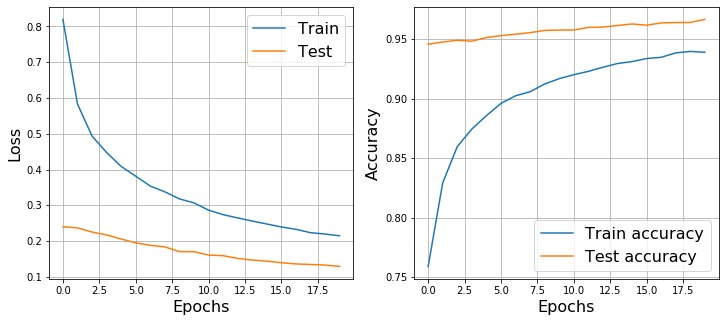

In [40]:
transform_cur = transforms.Compose([
                       transforms.RandomAffine(0, (0.1, 0.1)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_dataset_cur = MNIST('.', train=True, download=True, transform=transform_cur)
test_dataset_cur = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset_cur, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_cur, batch_size=32, shuffle=True)

tr_s, ts_s, tr_ac_s, ts_ac_s = train(nn, 20, 0.01)

### Вместе

Epoch 19... (Train/Test) NLL: 0.333/0.180	Accuracy: 0.904/0.950

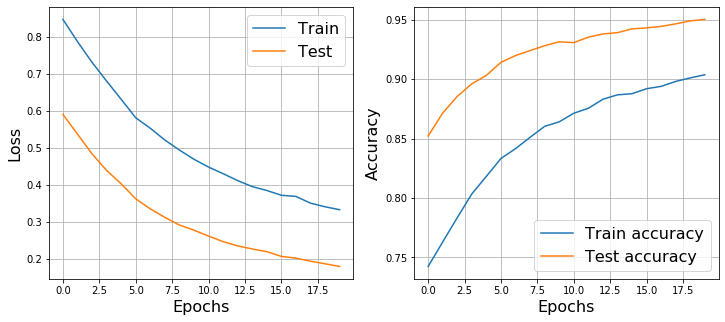

In [41]:
transform_cur = transforms.Compose([    
                           transforms.RandomAffine(15, (0.1, 0.1)),
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_dataset_cur = MNIST('.', train=True, download=True, transform=transform_cur)
test_dataset_cur = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset_cur, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_cur, batch_size=32, shuffle=True)

tr_s, ts_s, tr_ac_s, ts_ac_s = train(nn, 20, 0.01)

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

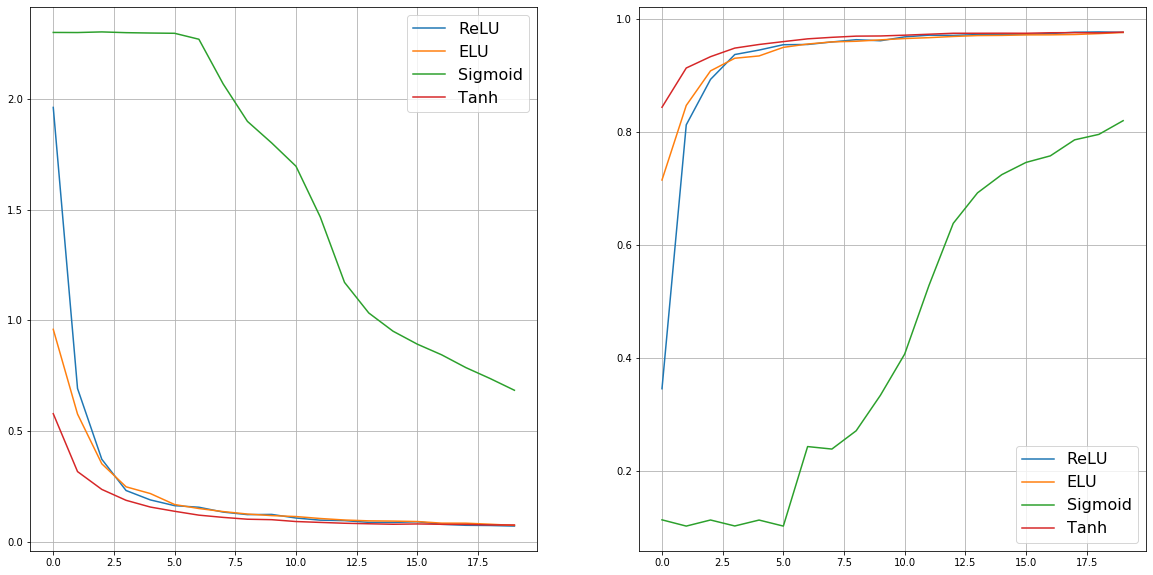

In [46]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(20)
fig.set_figheight(10)

axes[0].plot(ts_s_ReLu, label='ReLU')
axes[0].plot(ts_s_ELU, label='ELU')
axes[0].plot(ts_s_Sigm, label='Sigmoid')
axes[0].plot(ts_s_Tanh, label='Tanh')

axes[0].legend(loc=0, fontsize=16)
axes[0].grid()

axes[1].plot(ts_ac_s_ReLu, label='ReLU')
axes[1].plot(ts_ac_s_ELU, label='ELU')
axes[1].plot(ts_ac_s_Sigm, label='Sigmoid')
axes[1].plot(ts_ac_s_Tanh, label='Tanh')

axes[1].legend(loc=0, fontsize=16)
axes[1].grid()

In [48]:
print("Accuracy:\nSigmoid - ",ts_ac_s_Sigm[-1],"\nReLU - ",\
      ts_ac_s_ReLu[-1],"\nELU - ",ts_ac_s_ELU[-1],"\nTanh - ",ts_ac_s_Tanh[-1])

Accuracy:
Sigmoid -  0.8204872204472844 
ReLU -  0.9768370607028753 
ELU -  0.9766373801916933 
Tanh -  0.9772364217252396


Сигмоида с различными аугментациями:
* Небольшие вращения (-15, 15) - 0.918
* Случайные сдвиги - 0.959
* Шум - 0.967
* Вместе - 0.950

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Итак, мы видим, что сигмоида сходится намного медленее других рассмотренных функций активации. Итоговое качество у сигмоиды тоже хуже.
Лучшее качество у Tanh.
Все аугментации дают прирост, лучший прирост дает аугментация с шумом.